# EAS 4610
## Final Group Project
## Glacial Cycles (Pollard 1982)

### Dennis Frank
### Marcus Morris
### Nathan Warner

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import spdiags
import pandas as pd

# Introduction

# Equations

In [131]:
#Constants
a=0.81e-3 #Snowfall Constant, Unit:(1/yr) 
b=0.3e-6 #Ice Melt Constant, Unit:(1/(m*yr))
k_sens=25 #Insolation Sensitivity (m*day/Ly)
k_sens = k_sens / 41840 # 1 Ly = 41840 J/m^2
S=0 #Elevation of Current Sea Level
pi=917 #ice density (kg/m^3)
pw=1027 #sea water density (kg/m^3)
A = 5.77e-4 # 1/(m^3 yr)
alpha = 5
beta = 2
r = 0.3
nu = 100 # km^2/yr
nu = nu * 1000 * 1000

t_f = 10000
x_f = 4884000
dt = 0.1 #yr
dx = 55500 #m
nt = int(t_f/dt) + 1
nx = int(x_f/dx) + 1
x = np.linspace(0, x_f, nx)
t = np.linspace(0, t_f, nt)

c_nu = (nu * dt) / (dx**2)
c_A = (A * dt) / (4*dx**2)

In [133]:
#Function for Calculating the Mass Balance, G: (Snowfall - Ice Melt)
def G(h,h_prime,h_prev,h_prime_prev,E0,dQ): #h:ice height, h':bedrock elevation, x:distance, E0:current equilibrium altitude, dq:insolation change @ 65°N
    E = E0 + k_sens*dQ
    H = h+h_prime #Surface Elevation: H=h+h'
#    if (pi*h_prev < (pw*(S-h_prime_prev))) and (h_prime < S): #Calving Conditional Statement (maybe put this in separte fxn)
#        return -20
#     if (H-E) <= -1000:
#         return a*(H-E) - b*((H-E)**2)
#     else:
    return 0.56

In [136]:
h = np.zeros([nx, nt])
h_prime = np.zeros([nx, nt])

## Initial conditions
h_0 = np.zeros([nx])
h_prime_0 = np.zeros([nx])
h_naught = np.zeros([nx])

h[:, 0] = h_0
h_prime[:, 0] = h_prime_0

## EQUATION 3 MATRICES
h_prime_data = np.array([c_nu*np.ones(nx), (1-2*c_nu)*np.ones(nx), c_nu*np.ones(nx)])
h_prime_diags = np.array([-1, 0, 1])
h_prime_M_3 = spdiags(h_prime_data, h_prime_diags, nx, nx).toarray()

h_0_data = np.array([-c_nu*np.ones(nx), (2*c_nu)*np.ones(nx), -c_nu*np.ones(nx)])
h_0_diags = np.array([-1, 0, 1])
h_0_M_3 = spdiags(h_0_data, h_0_diags, nx, nx).toarray()

h_data = np.array([r*c_nu*np.ones(nx), (-2*r*c_nu)*np.ones(nx), r*c_nu*np.ones(nx)])
h_diags = np.array([-1, 0, 1])
h_M_3 = spdiags(h_data, h_diags, nx, nx).toarray()

## EQUATION 3 BOUNDARY CONDITIONS
h_prime_M_3[0, 0] = 0
h_prime_M_3[0, 1] = 0
h_prime_M_3[-1, -1] = 0
h_prime_M_3[-1, -2] = 0

h_0_M_3[0, 0] = 1
h_0_M_3[0, 1] = 0
h_0_M_3[-1, -1] = 1
h_0_M_3[-1, -2] = 0

h_M_3[0, 0] = 0
h_M_3[0, 1] = 0
h_M_3[-1, -1] = 0
h_M_3[-1, -2] = 0

#Define Insolation as a Function of Time (Q)
df = pd.read_csv('Milankovitch.dat',skiprows=1300,delim_whitespace=True, names=['year','lat','Q','x','y','z','v']) #only first 3 rows are of interest
Q = df['Q'].to_numpy() #values in W/m^2
n = np.ceil(len(t)/len(Q))
Q = list(np.repeat(Q,n)) #repeat values
#Run Loop to calculate dQ
Q_present=Q[-1]
dQ = np.ones((len(Q),1))
for i in np.arange(len(Q)):
    dQ[i] = Q[i] - Q_present
dQ = dQ.reshape(-1)
dQ = dQ * 60 * 60 * 24 # convert to J/(m^2 * day)
#Define Equilibrium-Line Altitude as a Function of latitude
E0 = (0.9e-3)*x - 99.9

## MASTER LOOP
time = 10000
for k in np.arange(0, time):
    # EQUATION 1 MATRICES
    K = np.zeros([nx])
    K[1:-1] = h[1:-1,k]**alpha + abs(((h[2:nx,k] - h[0:nx-2,k])/(2*dx)) + ((h_prime[2:nx,k] - h_prime[0:nx-2,k])/(2*dx)))**beta
#     K[0] = K[1]
#     K[-1] = K[nx - 2]

    h_1 = np.zeros(nx)
    h_1[0:nx-2] = c_A*K[0:nx-2] + 4*c_A*K[1:nx-1] - c_A*K[2:nx]
    h_2 = np.zeros(nx)
    h_2[1:nx-1] = 1 - 8*c_A*K[1:nx-1]
    h_2[0] = 1
    h_2[-1] = 1
    h_3 = np.zeros(nx)
    h_3[2:nx] = -c_A*K[0:nx-2] + 4*c_A*K[1:nx-1] + c_A*K[2:nx]
    h_diags = np.array([-1, 0, 1])
    h_M = spdiags(np.array([h_1, h_2, h_3]), h_diags, nx, nx).toarray()

    h_p_1 = np.zeros(nx)
    h_p_1[0:nx-2] = c_A*K[0:nx-2] + 4*c_A*K[1:nx-1] - c_A*K[2:nx]
    h_p_2 = np.zeros(nx)
    h_p_2[1:nx-1] = -8*c_A*K[1:nx-1]
    h_p_3 = np.zeros(nx)
    h_p_3[2:nx] = -c_A*K[0:nx-2] + 4*c_A*K[1:nx-1] + c_A*K[2:nx]
    h_p_diags = np.array([-1, 0, 1])
    h_p_M = spdiags(np.array([h_p_1, h_p_2, h_p_3]), h_diags, nx, nx).toarray()
    
    # Find G
    G_M = np.zeros(nx)
    this_dQ = dQ[k]
    G_M[0] = G(h[0, k], h_prime[0, k], h[0, k], h_prime[0, k], E0[0], this_dQ)
    
    for i in np.arange(1, nx-1):
        G_M[i] = G(h[i, k], h_prime[i, k], h[i-1, k], h_prime[i-1, k], E0[i], this_dQ)
        
    # Find h at next time step
    h_new = h_M@h[:,k] + h_p_M@h_prime[:,k] + G_M*dt
    h[:, k+1] = h_new.transpose()
    
    # Find h_prime at next time step    
    h_prime_new = h_prime_M_3@h_prime[:,k] + h_0_M_3@h_naught[:] + h_M_3@h[:,k]
    h_prime[:, k+1] = h_prime_new.transpose()
    
h[:,time]

array([560.        , 496.1977678 , 511.34613419, 469.67877297,
       488.76414485, 473.74132463, 483.74982028, 477.78622853,
       483.214234  , 480.17596123, 483.73561939, 481.60308783,
       484.47032108, 482.42651667, 485.15053585, 482.82717462,
       485.68022608, 482.93782563, 486.03575417, 482.87594972,
       486.23463111, 482.73794288, 486.31681459, 482.58931396,
       486.32788105, 482.4646882 , 486.30718391, 482.37669069,
       486.28330963, 482.32748766, 486.27474528, 482.31834023,
       486.2917181 , 482.35536182, 486.33579219, 482.45078427,
       486.39550305, 482.61840689, 486.43873603, 482.86111084,
       486.40635331, 483.15044328, 486.21568626, 483.40640755,
       485.78060063, 483.4957586 , 485.03995285, 483.26286551,
       483.96957168, 482.57934745, 482.56336868, 481.3755715 ,
       480.80341271, 479.6334892 , 478.64846709, 477.35598901,
       476.04320142, 474.53943132, 472.92981955, 471.16138511,
       469.25084879, 467.17983975, 464.94524578, 462.53

In [114]:
h[:,1800]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.])

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


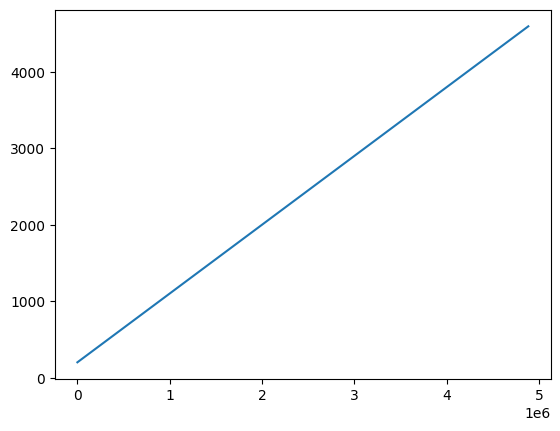

In [77]:
E0 = (0.9e-3)*x - 99.9
E = E0 + k_sens*dQ[0]
plt.plot(x,E)
k_sens
dQ[0]
E0

for i in np.arange(1, 20):
    print(i)

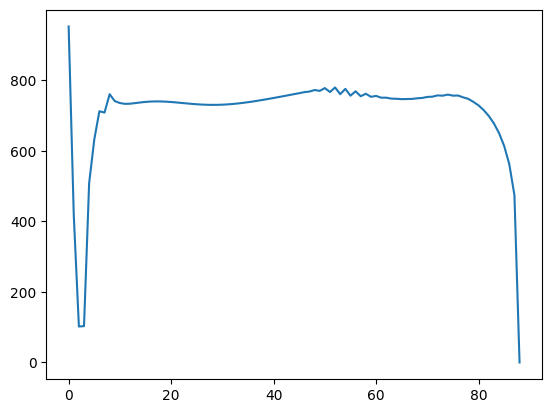

In [27]:
plt.plot(h[:,time])
plt.show()

# Numerical Methods

# Results

# Figures

# Video Walkthrough

# References